<a href="https://colab.research.google.com/github/Van-Wu1/cycle/blob/main/scr/py/s1_tmdslope.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip -q install geopandas shapely rasterio pyproj tqdm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 63.0 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')
!ls '/content/drive/MyDrive/CASA0004_Cycling/data'

Mounted at /content/drive
BoroughShp  GreatLondonShp  s1	s2_Env	s3


In [ ]:
import math
import numpy as np
import rasterio
from shapely.geometry import LineString, MultiLineString
from tqdm import tqdm

import geopandas as gpd
import pandas as pd
from shapely.geometry import Point
from shapely.strtree import STRtree
import numpy as np
import matplotlib.pyplot as plt
import os
import glob

In [ ]:
# 输入文件夹和输出文件夹
input_dir = "/content/drive/MyDrive/CASA0004_Cycling/data/s1/Roads_OT/CQI_1"
output_dir = "/content/drive/MyDrive/CASA0004_Cycling/data/s1/Roads_OT/CQI_final"

# 确保输出文件夹存在
os.makedirs(output_dir, exist_ok=True)

In [ ]:
# 可调参数
SLOPE_TIF = "/content/drive/MyDrive/CASA0004_Cycling/data/s1/Slope/slope.tif"
INTERVAL_M = 5.0             # 采样间距（米）
STAT_KIND  = "q3"             # "q3" | "mean" | "max"
SLOPE_UNIT = "degree"         # 栅格单位 or "percent"
CHUNK_SIZE = 20000            # 分块行数，视内存调整

In [ ]:
def line_points_every(line: LineString, step: float):
    """沿 LineString 每 step 米取点（含终点）。"""
    if not line or line.length == 0:
        return []
    n = max(1, int(math.floor(line.length / step)))
    dists = [i * step for i in range(n)] + [line.length]
    return [line.interpolate(d).coords[0] for d in dists]

def geom_points(geom, step: float):
    if geom is None:
        return []
    if isinstance(geom, LineString):
        return line_points_every(geom, step)
    if isinstance(geom, MultiLineString):
        pts = []
        for part in geom.geoms:
            pts.extend(line_points_every(part, step))
        return pts
    return []

def calc_stat(vals, kind="q3"):
    if not vals:
        return 0.0
    arr = np.asarray(vals, dtype=float)
    if kind == "mean": return float(np.nanmean(arr))
    if kind == "max":  return float(np.nanmax(arr))
    return float(np.nanpercentile(arr, 75))  # q3

def slope_to_percent(v, unit="degree"):
    if unit == "percent": return float(v)
    return float(math.tan(math.radians(v)) * 100.0)

def slope_to_factor(slope_pct: float) -> float:
    if slope_pct <= 2:   return 1.0
    if slope_pct <= 4:   return 0.95
    if slope_pct <= 6:   return 0.85
    if slope_pct <= 8:   return 0.75
    if slope_pct <= 10:  return 0.65
    return 0.9

# LTS的映射字典
def lts_to_factor(lts: float) -> float:
    if lts == 1: return 1.0
    if lts == 2: return 0.9
    if lts == 3: return 0.75
    if lts == 4: return 0.6
    return 0.9 #没关系这里没有空

In [ ]:
# 插入合并代码（全流程优化中）
# 遍历所有 geojson 文件
geojson_files = sorted(glob.glob(os.path.join(input_dir, "*.geojson")))

for file_path in geojson_files:
    print(f"正在处理：{file_path}")

    # 读取文件
    road_gdf = gpd.read_file(file_path)

    # TODO: 数据处理逻辑
    # # 打开坡度栅格
    ds = rasterio.open(SLOPE_TIF)
    raster_crs = ds.crs
    nodata = ds.nodata

    # 确保道路与栅格同一 CRS
    if road_gdf.crs is None:
        raise RuntimeError("road_gdf 没有 CRS，请先设定。")
    if raster_crs and road_gdf.crs.to_wkt() != raster_crs.to_wkt():
        road_gdf = road_gdf.to_crs(raster_crs)

    # 建字段
    if "proc_slope" not in road_gdf.columns:
        road_gdf["proc_slope"] = np.nan
    if "fac_3" not in road_gdf.columns:
        road_gdf["fac_3"] = np.nan
    if "fac_5" not in road_gdf.columns:
        road_gdf["fac_5"] = np.nan

    total = len(road_gdf)
    pbar = tqdm(total=total, desc="Sampling slope", unit="feat")

    start = 0
    while start < total:
        end = min(start + CHUNK_SIZE, total)
        sub = road_gdf.iloc[start:end].copy()

        proc_vals = np.zeros(len(sub))
        fac_vals  = np.ones(len(sub))

        # 为每条线生成采样点 → 栅格采样 → 统计
        for i, geom in enumerate(sub.geometry.values):
            pts = geom_points(geom, INTERVAL_M)
            if not pts:
                proc_vals[i] = 0.0
                fac_vals[i]  = 1.0
                continue

            # rasterio.sample 需要 [(x,y), ...]
            smps = list(ds.sample(pts))
            vals = []
            for s in smps:
                if s is None or len(s) == 0:
                    continue
                v = s[0]
                if v is None:
                    continue
                if (nodata is not None and v == nodata) or np.isnan(v):
                    continue
                vals.append(float(v))

            stat_v = calc_stat(vals, STAT_KIND)
            slope_pct = slope_to_percent(stat_v, SLOPE_UNIT)
            factor = slope_to_factor(slope_pct)

            proc_vals[i] = round(slope_pct, 2)
            fac_vals[i]  = round(factor, 2)

        # 写回
        road_gdf.loc[sub.index, "proc_slope"] = proc_vals
        road_gdf.loc[sub.index, "fac_3"] = fac_vals

        pbar.update(len(sub))
        start = end

    pbar.close()

    road_gdf["fac_5"] = road_gdf["stress_level"].apply(lts_to_factor)

    road_gdf["index"] = road_gdf["base_index"] * road_gdf["fac_1"] * road_gdf["fac_2"] * road_gdf["fac_3"] * road_gdf["fac_4"] * road_gdf["fac_5"]

    road_gdf["index"] = road_gdf["index"].clip(lower=0, upper=100).round().astype(int)

    road_gdf["index_10"] = road_gdf["index"] // 10

    # 构造输出路径（保留原文件名）
    file_name = os.path.basename(file_path)
    output_path = os.path.join(output_dir, file_name)

    # 保存
    road_gdf.to_file(output_path, driver="GeoJSON")
    print(f"已保存到：{output_path}")

print("全部文件处理完成！")

正在处理：/content/drive/MyDrive/CASA0004_Cycling/data/s1/Roads_OT/CQI_1/CQIwithoutslop1.geojson


Sampling slope: 100%|██████████| 5041/5041 [00:13<00:00, 383.65feat/s]


已保存到：/content/drive/MyDrive/CASA0004_Cycling/data/s1/Roads_OT/CQI_final/CQIwithoutslop1.geojson
正在处理：/content/drive/MyDrive/CASA0004_Cycling/data/s1/Roads_OT/CQI_1/CQIwithoutslop2.geojson


Sampling slope: 100%|██████████| 15634/15634 [00:49<00:00, 313.52feat/s]


已保存到：/content/drive/MyDrive/CASA0004_Cycling/data/s1/Roads_OT/CQI_final/CQIwithoutslop2.geojson
正在处理：/content/drive/MyDrive/CASA0004_Cycling/data/s1/Roads_OT/CQI_1/CQIwithoutslop3.geojson


Sampling slope: 100%|██████████| 2821/2821 [00:11<00:00, 249.26feat/s]


已保存到：/content/drive/MyDrive/CASA0004_Cycling/data/s1/Roads_OT/CQI_final/CQIwithoutslop3.geojson
正在处理：/content/drive/MyDrive/CASA0004_Cycling/data/s1/Roads_OT/CQI_1/CQIwithoutslop4.geojson


Sampling slope: 100%|██████████| 25071/25071 [01:04<00:00, 386.55feat/s]


已保存到：/content/drive/MyDrive/CASA0004_Cycling/data/s1/Roads_OT/CQI_final/CQIwithoutslop4.geojson
正在处理：/content/drive/MyDrive/CASA0004_Cycling/data/s1/Roads_OT/CQI_1/CQIwithoutslop5.geojson


Sampling slope: 100%|██████████| 57490/57490 [01:45<00:00, 546.82feat/s]


已保存到：/content/drive/MyDrive/CASA0004_Cycling/data/s1/Roads_OT/CQI_final/CQIwithoutslop5.geojson
正在处理：/content/drive/MyDrive/CASA0004_Cycling/data/s1/Roads_OT/CQI_1/CQIwithoutslop6.geojson


Sampling slope: 100%|██████████| 15422/15422 [00:41<00:00, 371.28feat/s]


已保存到：/content/drive/MyDrive/CASA0004_Cycling/data/s1/Roads_OT/CQI_final/CQIwithoutslop6.geojson
正在处理：/content/drive/MyDrive/CASA0004_Cycling/data/s1/Roads_OT/CQI_1/CQIwithoutslop7.geojson


Sampling slope: 100%|██████████| 10030/10030 [00:30<00:00, 324.57feat/s]


已保存到：/content/drive/MyDrive/CASA0004_Cycling/data/s1/Roads_OT/CQI_final/CQIwithoutslop7.geojson
正在处理：/content/drive/MyDrive/CASA0004_Cycling/data/s1/Roads_OT/CQI_1/CQIwithoutslop8.geojson


Sampling slope: 100%|██████████| 26070/26070 [01:03<00:00, 411.09feat/s]


已保存到：/content/drive/MyDrive/CASA0004_Cycling/data/s1/Roads_OT/CQI_final/CQIwithoutslop8.geojson
正在处理：/content/drive/MyDrive/CASA0004_Cycling/data/s1/Roads_OT/CQI_1/CQIwithoutslop9.geojson


Sampling slope: 100%|██████████| 6497/6497 [00:21<00:00, 306.46feat/s]


已保存到：/content/drive/MyDrive/CASA0004_Cycling/data/s1/Roads_OT/CQI_final/CQIwithoutslop9.geojson
全部文件处理完成！


In [ ]:
print("CRS:", ds.crs)
print("Width (cols):", ds.width)
print("Height (rows):", ds.height)
print("Transform:", ds.transform)
print("Pixel size (res):", ds.res)


CRS: EPSG:27700
Width (cols): 11676
Height (rows): 9016
Transform: | 5.00, 0.00, 503573.42|
| 0.00,-5.00, 200936.64|
| 0.00, 0.00, 1.00|
Pixel size (res): (5.000138720452213, 5.000138720452213)


In [ ]:
# 必要的copy
copy = road_gdf

count     6497.0
unique       6.0
top          1.0
freq      2508.0
Name: fac_3, dtype: float64


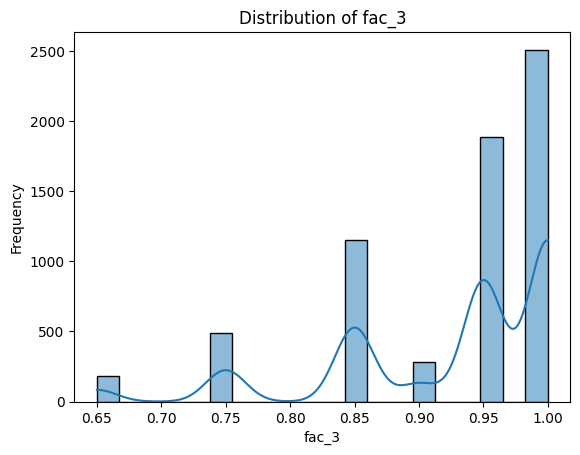

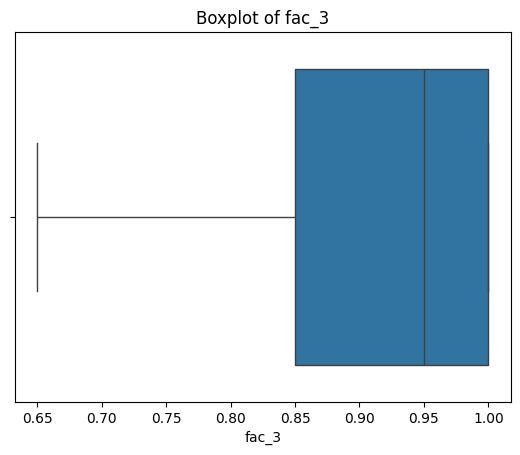

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1. 基本统计信息
print(road_gdf['fac_3'].describe())

# 2. 直方图 + 核密度曲线
sns.histplot(road_gdf['fac_3'], kde=True, bins=20)
plt.title('Distribution of fac_3')
plt.xlabel('fac_3')
plt.ylabel('Frequency')
plt.show()

# 3. 箱线图（看中位数和异常值）
sns.boxplot(x=road_gdf['fac_3'])
plt.title('Boxplot of fac_3')
plt.show()


count    6497.000000
mean        5.221139
std        28.467361
min         0.000000
25%         1.300000
50%         2.750000
75%         4.700000
max       713.450000
Name: proc_slope, dtype: float64


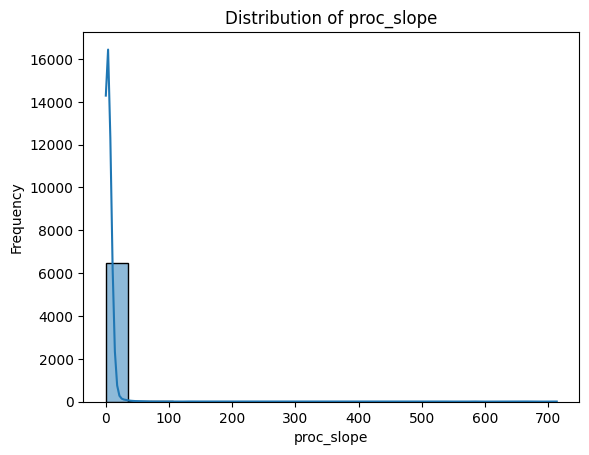

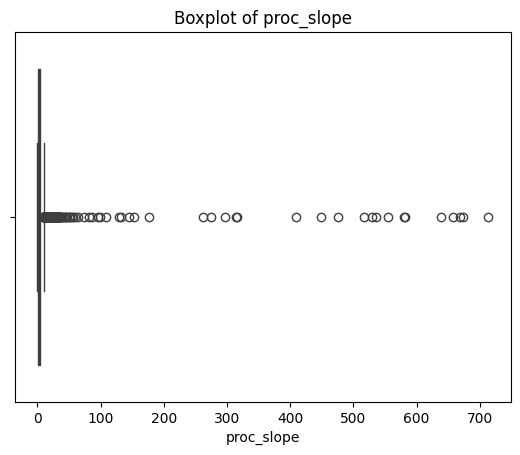

In [ ]:
# 1. 基本统计信息
print(road_gdf['proc_slope'].describe())

# 2. 直方图 + 核密度曲线
sns.histplot(road_gdf['proc_slope'], kde=True, bins=20)
plt.title('Distribution of proc_slope')
plt.xlabel('proc_slope')
plt.ylabel('Frequency')
plt.show()

# 3. 箱线图（看中位数和异常值）
sns.boxplot(x=road_gdf['proc_slope'])
plt.title('Boxplot of proc_slope')
plt.show()


In [ ]:
print("CRS:", ds.crs)
print("Width (cols):", ds.width)
print("Height (rows):", ds.height)
print("Transform:", ds.transform)
print("Pixel size (res):", ds.res)

CRS: EPSG:27700
Width (cols): 11676
Height (rows): 9016
Transform: | 5.00, 0.00, 503573.42|
| 0.00,-5.00, 200936.64|
| 0.00, 0.00, 1.00|
Pixel size (res): (5.000138720452213, 5.000138720452213)
